This is a noteboook that illustrates how to encode structured data for use in Large Language Models.  It is Part 1 of a two part tutorial from **KDD'24**.

If you find this tutorial useful or want to know more, please consider our publication:  
[**Talk like a Graph: Encoding Graphs for Large Language Models**](https://openreview.net/pdf?id=IuXR1CCrSi)

```
@inproceedings{
fatemi2024talk,
  title={Talk like a Graph: Encoding Graphs for Large Language Models},
  author={Bahare Fatemi and Jonathan Halcrow and Bryan Perozzi},
  booktitle={The Twelfth International Conference on Learning Representations},
  year={2024},
  url={https://openreview.net/forum?id=IuXR1CCrSi}
}
```







## Tutorial Part I:  Text Encoding of Graph Information

This first notebook focuses on using text serialization methods from **Talk Like a Graph** to perform graph reasoning tasks with off-the-shelf LLMs.  This notebook focuses on using static **Gemini** models (which have free API quota), but the techniques (and code) here are generally applicable to any LLM.


Notebook Outline:

1.   Setup (Install Dependencies, get Google Cloud API key)
1.   Dataset creation
1.   Graph-to-Text conversion
1.   Evaluation
1.   Exercise:  *Graph Encoding Challenge*
1.   Exercise: DBLP Dataset



# Setup

## Get Google AI Studio Key

Go to [Google AI Studio](https://aistudio.google.com/app/u/1/apikey) and click on the `Create API Key` button.  Follow prompts in dialog to setup an API key with a new Google Cloud Project.

Then add the API key to your colab secrets (using the side panel 🔑) as in the picture below:

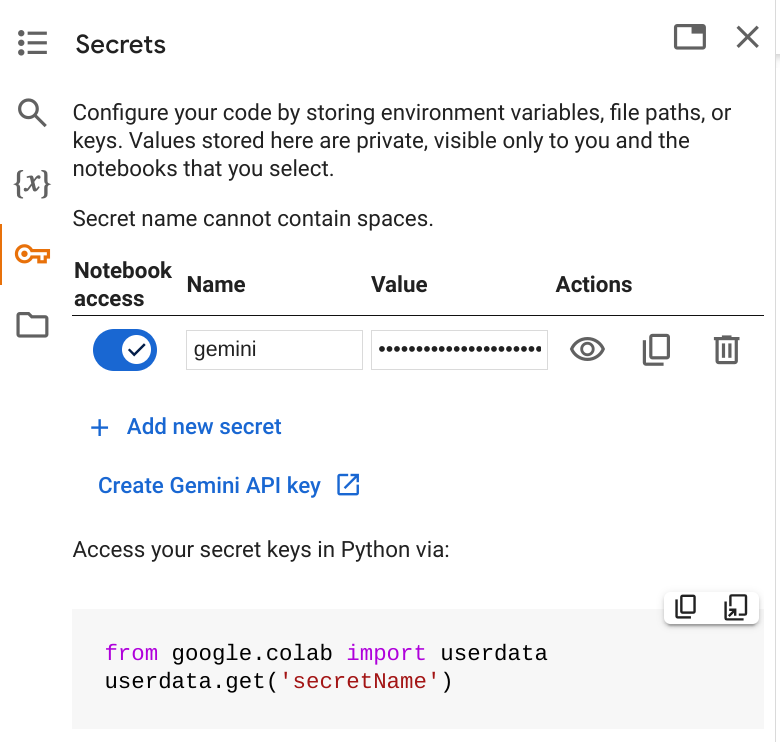

In [ ]:
# @title Load API Key
from google.colab import userdata
API_KEY = userdata.get('gemini')

## Install Dependencies

*This will take a minute or two...*

In [ ]:
%%capture
!pip install xmltodict
!pip install networkx ipysigma

In [ ]:
from collections import OrderedDict
from dataclasses import dataclass
from functools import cache
import itertools
from typing import Callable
import networkx as nx
import requests
import xmltodict
from ipysigma import Sigma
import math
import base64
import json

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

### DBLP to graph API

In [ ]:
@dataclass(frozen=True)
class Author:
  id: str
  name: str

@dataclass(frozen=True)
class Paper:
  id: str
  title: str
  date: str
  author_ids: list[str]

In [ ]:
@cache
def _load_page(author_id: str) -> OrderedDict:
  data = requests.get(f'https://dblp.org/pid/{author_id}.xml')
  return xmltodict.parse(data.text)

In [ ]:
def clean_name(name: str) -> str:
  return ''.join([x for x in name if str.isalpha(x) or x in (' ', '-')])

def read_authors(xmldata: OrderedDict, author_pid: str) -> list[Author]:
  authors = [Author(id=author_pid, name=xmldata['dblpperson']['@name'])]
  for item in xmldata['dblpperson']['coauthors']['co']:
    na = item['na']
    if isinstance(na, list): na = na[0]
    authors.append(Author(id=na['@pid'], name=clean_name(na['#text'])))
  return authors

def read_papers(xmldata: OrderedDict) -> list[Paper]:
  papers = []
  for article in xmldata['dblpperson']['r']:
    if not isinstance(article, dict):
      print('???', article)
      continue
    [article_key] = article.keys()
    article = article[article_key]
    if 'author' not in article:
      print('!!!', article)
      continue
    if isinstance(article['author'], list):
      author_ids = [x['@pid'] for x in article['author']]
    else:
      author_ids = [article['author']['@pid']]
    papers.append(Paper(id=article['@key'], title=article['title'], date=article['@mdate'], author_ids=author_ids))
  return papers

In [ ]:
def dblp_data(author_id: str) -> [list[Author], list[Paper]]:
  xmldata = _load_page(author_id)
  return (read_authors(xmldata, author_pid), read_papers(xmldata))


def _expand(id2author: list[str]) -> list[str]:
  result = []
  for author_id in id2author:
    authors, _ = dblp_data(author_id)
    result.extend([x.id for x in authors])
  return list(set(result))


def coauthorship_graph(
    authors: dict[str, Author], papers: dict[str, Paper]
) -> nx.Graph:
  g = nx.Graph()
  for a in authors.keys():
    g.add_node(a, name=authors[a].name, id=authors[a].id)
  # g.add_nodes_from(authors.keys())
  for paper in papers.values():
    g.add_edges_from(itertools.combinations(paper.author_ids, 2))
  return g


def author_paper_graph(
    authors: dict[str, Author], papers: dict[str, Paper]
) -> nx.Graph:
  g = nx.Graph()
  g.add_nodes_from(authors.keys())
  g.add_nodes_from(papers.keys())
  for paper in papers.values():
    g.add_edges_from([paper.id, author] for author in paper.author_ids)
  return g


def dblp_graph(
    root_id: str,
    n_hops: int = 1,
    graph_fn: Callable[
        [dict[str, Author], dict[str, Paper]], nx.Graph
    ] = coauthorship_graph,
) -> nx.Graph:
  author_list = [root_id]
  for _ in range(n_hops - 1):
    author_list = _expand(author_list)
  authors, papers = zip(*[dblp_data(x) for x in author_list])
  authors = {author.id: author for author in itertools.chain(*authors)}
  papers = {paper.id: paper for paper in itertools.chain(*papers)}
  return graph_fn(authors, papers)

### Load Talk Like a Graph Library

In [ ]:
!git clone https://github.com/google-research/talk-like-a-graph.git
import sys
sys.path.insert(0, "/content/talk-like-a-graph")

In [ ]:
from talk_like_a_graph.graph_generators import generate_graphs
from talk_like_a_graph.graph_tasks import CycleCheck, ShortestPath, NodeCount

In [ ]:
import google.generativeai as genai
import os

genai.configure(api_key=API_KEY)

### Talk like a Graph code
import random
import networkx as nx
import numpy as np
import tensorflow as tf

### Load Saved Data


In [ ]:
saved_coauthorship_graph = nx.node_link_graph(json.loads(base64.b64decode(b'''eyJkaXJlY3RlZCI6IGZhbHNlLCAibXVsdGlncmFwaCI6IGZhbHNlLCAiZ3JhcGgiOiB7fSwgIm5vZGVzIjogW3sibmFtZSI6ICJCcnlhbiBQZXJvenppIiwgImlkIjogIjkxLzEwODEzIn0sIHsibmFtZSI6ICJTYW1pIEFidS1FbC1IYWlqYSIsICJpZCI6ICIxMjcvNjYyMCJ9LCB7Im5hbWUiOiAiTGVtYW4gQWtvZ2x1IiwgImlkIjogIjAyLzY5NzkifSwgeyJuYW1lIjogIlJhbWkgQWwtUmZvdSIsICJpZCI6ICIxMjIvMzAzMyJ9LCB7Im5hbWUiOiAiQWxleGFuZGVyIEEgQWxlbWkiLCAiaWQiOiAiMTYwLzgxNTgifSwgeyJuYW1lIjogIk5hemFuaW4gQWxpcG91cmZhcmQiLCAiaWQiOiAiMjAwLzAxNzgifSwgeyJuYW1lIjogIkZpbGlwZSBNaWd1ZWwgR29uXHUwMGU3YWx2ZXMgZGUgQWxtZWlkYSIsICJpZCI6ICIyNzYvNTcwMiJ9LCB7Im5hbWUiOiAiS3lyaWFrb3MgQXhpb3RpcyIsICJpZCI6ICIxNzYvNTEzOSJ9LCB7Im5hbWUiOiAiS2VzaGF2IEJhbGFzdWJyYW1hbmlhbiIsICJpZCI6ICIyNTgvOTEyOCJ9LCB7Im5hbWUiOiAiTWF0dCBCYXJuZXMgIiwgImlkIjogIjE2MC85OTEyIn0sIHsibmFtZSI6ICJNb2hhbW1hZCBIb3NzZWluIEJhdGVuaSAiLCAiaWQiOiAiMjIvNDczOSJ9LCB7Im5hbWUiOiAiUGV0ZXIgVyBCYXR0YWdsaWEiLCAiaWQiOiAiNDEvMzQwMCJ9LCB7Im5hbWUiOiAiU3BlbmNlciBCZWVjaGVyIiwgImlkIjogIjE1NC83ODAzIn0sIHsibmFtZSI6ICJYdWUgQmVuIiwgImlkIjogIjE1OS85NTE3In0sIHsibmFtZSI6ICJNYXJ0aW4gQmxhaXMiLCAiaWQiOiAiMjI1LzQxMTUifSwgeyJuYW1lIjogIkFsZWtzYW5kYXIgQm9qY2hldnNraSIsICJpZCI6ICIyMDMvODExNCJ9LCB7Im5hbWUiOiAiTmVzbGloYW4gQnVsdXQiLCAiaWQiOiAiMTk0LzQ4MjQifSwgeyJuYW1lIjogIk1pY2hhZWwgQnVycm93cyIsICJpZCI6ICI3My82MTUifSwgeyJuYW1lIjogIkthaWRpIENhbyIsICJpZCI6ICIyMDMvODIwNyJ9LCB7Im5hbWUiOiAiSW5lcyBDaGFtaSIsICJpZCI6ICIxODQvMjAyMCJ9LCB7Im5hbWUiOiAiSGFvY2hlbiBDaGVuIiwgImlkIjogIjE3Ni8yNjIwIn0sIHsibmFtZSI6ICJNdWhhbyBDaGVuIiwgImlkIjogIjE3My8yNjA4In0sIHsibmFtZSI6ICJUaW5nIENoZW4iLCAiaWQiOiAiMTkvMTc2NiJ9LCB7Im5hbWUiOiAiWWFucWluZyBDaGVuIiwgImlkIjogIjY4LzE0MjUifSwgeyJuYW1lIjogIlpoaWthaSBDaGVuIiwgImlkIjogIjkyLzQwIn0sIHsibmFtZSI6ICJaaGl5dWFuIENoZW5nICIsICJpZCI6ICI1OC83MjExLTIifSwgeyJuYW1lIjogIkVkIEggQ2hpIiwgImlkIjogIjEzLzMxMCJ9LCB7Im5hbWUiOiAiSm9zaHVhIFYgRGlsbG9uIiwgImlkIjogIjc4Lzg3MDAifSwgeyJuYW1lIjogIkthaXplIERpbmciLCAiaWQiOiAiMjM0LzY4NzgifSwgeyJuYW1lIjogIkppYWxpbiBEb25nIiwgImlkIjogIjIxMS8zOTY4In0sIHsibmFtZSI6ICJBcm5vIEVpZ2Vud2lsbGlnIiwgImlkIjogImUvQXJub0VpZ2Vud2lsbGlnIn0sIHsibmFtZSI6ICJQZXRlciBFbmdsZXJ0IiwgImlkIjogIjEzMi85MTEzIn0sIHsibmFtZSI6ICJBbGVzc2FuZHJvIEVwYXN0byIsICJpZCI6ICI1OC83ODAyIn0sIHsibmFtZSI6ICJIb3NzZWluIEVzZmFuZGlhcmkiLCAiaWQiOiAiMTQ2Lzc3NDYifSwgeyJuYW1lIjogIkJhaGFyZSBGYXRlbWkiLCAiaWQiOiAiMTgyLzIzNTYifSwgeyJuYW1lIjogIk9sZWtzYW5kciBGZXJsdWRpbiIsICJpZCI6ICIzMjQvMjYxMyJ9LCB7Im5hbWUiOiAiSGVuZHJpayBGaWNodGVuYmVyZ2VyIiwgImlkIjogIjEzMy8yMDI5In0sIHsibmFtZSI6ICJFZHVhcmRvIEZsZXVyeSIsICJpZCI6ICIyMTEvODA3MyJ9LCB7Im5hbWUiOiAiS2ltb24gRm91bnRvdWxha2lzIiwgImlkIjogIjE0OS81Nzk5In0sIHsibmFtZSI6ICJBcmFtIEdhbHN0eWFuIiwgImlkIjogIjE2LzM0MTEifSwgeyJuYW1lIjogIkpvaGFubmVzIEdhc3RlaWdlciIsICJpZCI6ICIyMjgvNzg5NyJ9LCB7Im5hbWUiOiAiU3RlcGhhbiBHXHUwMGZjbm5lbWFubiIsICJpZCI6ICI0My8zMDExIn0sIHsibmFtZSI6ICJKYW1lcyBUIEhhbGJlcnQiLCAiaWQiOiAiMTMwLzYzMzAifSwgeyJuYW1lIjogIkpvbmF0aGFuIEhhbGNyb3ciLCAiaWQiOiAiMjcxLzA3NjkifSwgeyJuYW1lIjogIkV0aGFuIEhhbGwiLCAiaWQiOiAiMzc4LzQyOTIifSwgeyJuYW1lIjogIkppYXdlaSBIYW4gIiwgImlkIjogImgvSmlhd2VpSGFuIn0sIHsibmFtZSI6ICJIcmF5ciBIYXJ1dHl1bnlhbiIsICJpZCI6ICIxOTgvMTQ2NSJ9LCB7Im5hbWUiOiAiRGFrZSBIZSIsICJpZCI6ICI0Ni81NDY2In0sIHsibmFtZSI6ICJaaWhhbyBIZSIsICJpZCI6ICIyNDYvMjk2MSJ9LCB7Im5hbWUiOiAiTGljaGFuIEhvbmciLCAiaWQiOiAiODUvNDY5NyJ9LCB7Im5hbWUiOiAiWWlmYW4gSHUgIiwgImlkIjogIjkyLzQ5OC0xIn0sIHsibmFtZSI6ICJaaW5pdSBIdSIsICJpZCI6ICIxODAvNTQzNiJ9LCB7Im5hbWUiOiAiRGkgSHVhbmciLCAiaWQiOiAiNDUvNzgwIn0sIHsibmFtZSI6ICJZdXpob25nIEh1YW5nIiwgImlkIjogIjIxMy84MDgwIn0sIHsibmFtZSI6ICJZaXpodSBKaWFvIiwgImlkIjogIjI1MC85NzU3In0sIHsibmFtZSI6ICJXZWkgSmluICIsICJpZCI6ICI2Ni8yMTczLTkifSwgeyJuYW1lIjogIkFtb2wgS2Fwb29yIiwgImlkIjogIjIxNS81MDE0In0sIHsibmFtZSI6ICJNZWhyYW4gS2F6ZW1pIiwgImlkIjogIjE0OS8xMjgzIn0sIHsibmFtZSI6ICJWaXZlayBLdWxrYXJuaSIsICJpZCI6ICI5Mi85OTIyIn0sIHsibmFtZSI6ICJTaWx2aW8gTGF0dGFuemkiLCAiaWQiOiAiNDYvNjYxMSJ9LCB7Im5hbWUiOiAiSm9vbnNlb2sgTGVlIiwgImlkIjogIjc3LzEzMTkifSwgeyJuYW1lIjogIktyaXN0aW5hIExlcm1hbiIsICJpZCI6ICI5OS80MzMifSwgeyJuYW1lIjogIkp1cmUgTGVza292ZWMiLCAiaWQiOiAibC9KdXJlTGVza292ZWMifSwgeyJuYW1lIjogIkFuZHJldyBMZXZpbmUiLCAiaWQiOiAiMDYvMTA4MTQifSwgeyJuYW1lIjogIkJpbmdoZW5nIExpIiwgImlkIjogIjIzMS8xOTA0In0sIHsibmFtZSI6ICJXYWkgTG9rIFNpYm9uIExpIiwgImlkIjogIjI1OC81MDAzIn0sIHsibmFtZSI6ICJBbGJlcnQgSmlvbmdxaWFuIExpYW5nIiwgImlkIjogIjM0OC82NDk4In0sIHsibmFtZSI6ICJBbmRyXHUwMGU5IExpbmhhcmVzIiwgImlkIjogIjEzNy8zMjUyIn0sIHsibmFtZSI6ICJIdWFuIExpdSAiLCAiaWQiOiAiOTIvMzA5LTEifSwgeyJuYW1lIjogIkh1aSBMaXUgIiwgImlkIjogIjkzLzQwMTAtMzEifSwgeyJuYW1lIjogIkppbmd6aGUgTGl1IiwgImlkIjogIjMzOS83NTU4In0sIHsibmFtZSI6ICJMdXlhbmcgTGl1IiwgImlkIjogIjY5LzgxNjcifSwgeyJuYW1lIjogIk1pY2hhbCBMdWthc2lrIiwgImlkIjogIjcyLzExMzM4In0sIHsibmFtZSI6ICJLYXJpc2htYSBNYWxrYW4iLCAiaWQiOiAiMjYzLzk5NTkifSwgeyJuYW1lIjogIkhhaXRhbyBNYW8iLCAiaWQiOiAiMjIxLzY1MTYifSwgeyJuYW1lIjogIkVsYW4gTWFya293aXR6IiwgImlkIjogIjI4NC85NDAxIn0sIHsibmFtZSI6ICJCcmFuZG9uIEEgTWF5ZXIiLCAiaWQiOiAiMjcvMTEyNjEifSwgeyJuYW1lIjogIkNocmlzIE1jQ3ViYmluIiwgImlkIjogIjI5Ny8xODIxIn0sIHsibmFtZSI6ICJDaGFyaXRoIE1lbmRpcyIsICJpZCI6ICIxNjMvMzE3NSJ9LCB7Im5hbWUiOiAiVmFoYWIgUyBNaXJyb2tuaSIsICJpZCI6ICJtL1ZhaGFiU01pcnJva25pIn0sIHsibmFtZSI6ICJNZWhybm9vc2ggTWlydGFoZXJpIiwgImlkIjogIjIzNi80NDQ5In0sIHsibmFtZSI6ICJGcmVkIE1vcnN0YXR0ZXIiLCAiaWQiOiAiNTEvOTY4NyJ9LCB7Im5hbWUiOiAiQWxleGFuZHJ1IE1vc29pIiwgImlkIjogIjI3MS8xMDI1In0sIHsibmFtZSI6ICJFbW1hbnVlbCBNXHUwMGZjbGxlciIsICJpZCI6ICI1NS82ODk5In0sIHsibmFtZSI6ICJNYXJpbmEgTXVua2hvZXZhIiwgImlkIjogIjIxNS8zNjgyIn0sIHsibmFtZSI6ICJLZXZpbiBNdXJwaHkgIiwgImlkIjogIjI2LzI1OTkifSwgeyJuYW1lIjogIlNoYXduIE9CYW5pb24iLCAiaWQiOiAiMTI3Lzc0OTcifSwgeyJuYW1lIjogIkpvaG4gUGFsb3dpdGNoIiwgImlkIjogIjE3NS8xMjMxIn0sIHsibmFtZSI6ICJNaWhpciBQYXJhZGthciIsICJpZCI6ICIyMDUvMzkwOCJ9LCB7Im5hbWUiOiAiSmFuIFBmZWlmZXIiLCAiaWQiOiAiMTYzLzIzMzkifSwgeyJuYW1lIjogIk1hbmdwbyBNYW5ncG8gUGhvdGhpbGltdGhhbmEiLCAiaWQiOiAiMzY5Lzc2ODkifSwgeyJuYW1lIjogIlBoaXRjaGF5YSBNYW5ncG8gUGhvdGhpbGltdGhhbmEiLCAiaWQiOiAiMTI3LzMxMjgifSwgeyJuYW1lIjogIk5hdGFsaWEgUG9ub21hcmV2YSAiLCAiaWQiOiAiNzEvNjc2OC0xIn0sIHsibmFtZSI6ICJTdGVmYW4gUG9zdGF2YXJ1IiwgImlkIjogIjE5NC8xNTcwIn0sIHsibmFtZSI6ICJBYmR1bCBSYWhtYW4iLCAiaWQiOiAiODcvMTAxMDAifSwgeyJuYW1lIjogIkRlZXBhayBSYW1hY2hhbmRyYW4iLCAiaWQiOiAiODAvNzAzIn0sIHsibmFtZSI6ICJDaHJpc3RvcGhlciBSXHUwMGU5IiwgImlkIjogInIvQ2hyaXN0b3BoZXJSZSJ9LCB7Im5hbWUiOiAiQXJpYSBSZXphZWkiLCAiaWQiOiAiMTYwLzg2NzcifSwgeyJuYW1lIjogIkJlbmVkZWsgUm96ZW1iZXJjemtpIiwgImlkIjogIjIxNS8zNzQyIn0sIHsibmFtZSI6ICJTYW0gUnV0aCIsICJpZCI6ICIyNzEvMDYzNyJ9LCB7Im5hbWUiOiAiSmFjayBTYWFsd2VhY2h0ZXIiLCAiaWQiOiAiMTg0LzAwMzMifSwgeyJuYW1lIjogIlJ1c2xhbiBTYWxha2h1dGRpbm92IiwgImlkIjogIjYyLzU4ODQifSwgeyJuYW1lIjogIlBhdHJpY2lhIElnbGVzaWFzIFNcdTAwZTFuY2hleiIsICJpZCI6ICIxMzEvNzE2OSJ9LCB7Im5hbWUiOiAiQWx2YXJvIFNhbmNoZXotR29uemFsZXoiLCAiaWQiOiAiMjIyLzE4ODkifSwgeyJuYW1lIjogIkNsYXl0b24gU2FuZm9yZCIsICJpZCI6ICIyMzIvMTc5NyJ9LCB7Im5hbWUiOiAiTWljaGFlbCBTY2h1ZXBwZXJ0IiwgImlkIjogIjE2OS8xNzQyIn0sIHsibmFtZSI6ICJTdW5neW9uZyBTZW8iLCAiaWQiOiAiMTc4LzMyMDkifSwgeyJuYW1lIjogIkplbm5pZmVyIFNoZSIsICJpZCI6ICIyNDMvNTc2MCJ9LCB7Im5hbWUiOiAiU3RldmVuIFNraWVuYSIsICJpZCI6ICJzL1N0ZXZlblNraWVuYSJ9LCB7Im5hbWUiOiAiR3JlZyBWZXIgU3RlZWciLCAiaWQiOiAiODIvOTA1OCJ9LCB7Im5hbWUiOiAiS2V4dWFuIFN1biAiLCAiaWQiOiAiMTE1LzY0NjYtMiJ9LCB7Im5hbWUiOiAiWGlhb2ZlaSBTdW4iLCAiaWQiOiAiODcvNzI5NyJ9LCB7Im5hbWUiOiAiSmlsaWFuZyBUYW5nIiwgImlkIjogIjY0LzEwODEyIn0sIHsibmFtZSI6ICJNYXl1ciBUaGFrdXIiLCAiaWQiOiAiNTgvNTQ5MiJ9LCB7Im5hbWUiOiAiWWluZ3RhbyBUaWFuIiwgImlkIjogIjE4MC81MzM1In0sIHsibmFtZSI6ICJMb25nIFRyYW4tVGhhbmgiLCAiaWQiOiAiNDYvODMzMyJ9LCB7Im5hbWUiOiAiQW50b24gVHNpdHN1bGluIiwgImlkIjogIjIxNy8xNjY4In0sIHsibmFtZSI6ICJLZXZpbiBWaWxsZWxhIiwgImlkIjogIjMyNC8yNTY3In0sIHsibmFtZSI6ICJMaXNhIFdhbmciLCAiaWQiOiAiMTk4Lzc0MjMifSwgeyJuYW1lIjogIlJ1b3hpIFdhbmciLCAiaWQiOiAiNzIvMTEyNDQifSwgeyJuYW1lIjogIkRhdmlkIFdvbmciLCAiaWQiOiAiNDcvMzE4In0sIHsibmFtZSI6ICJZdWUgV3UgIiwgImlkIjogIjQxLzU5NzktMSJ9LCB7Im5hbWUiOiAiTGluIFlhbmcgIiwgImlkIjogIjE2Ni82MjY0In0sIHsibmFtZSI6ICJTaGVuZ2hhbyBZYW5nICIsICJpZCI6ICI0MS80NDgyLTIifSwgeyJuYW1lIjogIk11c3RhZmEgWWFzaXIiLCAiaWQiOiAiMzUyLzQyMzcifSwgeyJuYW1lIjogIkppbnllb25nIFlpbSIsICJpZCI6ICIxNzYvNDIwNSJ9LCB7Im5hbWUiOiAiTWluamkgWW9vbiIsICJpZCI6ICIyMDUvMjY1MSJ9LCB7Im5hbWUiOiAiU29uZyBZdSIsICJpZCI6ICI1NC8xMjE2In0sIHsibmFtZSI6ICJEdXN0aW4gWmVsbGUiLCAiaWQiOiAiMjM5LzYwNzAifSwgeyJuYW1lIjogIlBlaWxpbiBaaG9uZyIsICJpZCI6ICIxNDgvOTYzMiJ9LCB7Im5hbWUiOiAiWWFucWkgWmhvdSIsICJpZCI6ICIxNDIvMzIwMiJ9LCB7Im5hbWUiOiAiUWkgWmh1ICIsICJpZCI6ICI2Ni81OTIzLTgifV0sICJsaW5rcyI6IFt7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTgyLzIzNTYifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjI3MS8wNzY5In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE0OS8xMjgzIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxMjIvMzAzMyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjExLzM5NjgifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE2Ni82MjY0In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMzIvMTc5NyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMzc4LzQyOTIifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIm0vVmFoYWJTTWlycm9rbmkifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjI2My85OTU5In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNzYvNDIwNSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTc1LzEyMzEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE3OC8zMjA5In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI5Mi80MCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjIxLzY1MTYifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjMzOS83NTU4In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI1NC8xMjE2In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMzEvMTkwNCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNjYvMjE3My05In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI5My80MDEwLTMxIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI2NC8xMDgxMiJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNTUvNjg5OSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTQ2Lzc3NDYifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjIyLzQ3MzkifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjgwLzcwMyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjA1LzI2NTEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjQxLzU5NzktMSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNjIvNTg4NCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjEzMy8yMDI5In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxMjcvNjYyMCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjAzLzgyMDcifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjEyNy8zMTI4In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNDIvMzIwMiJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTYzLzMxNzUifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogImwvSnVyZUxlc2tvdmVjIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIzNjkvNzY4OSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNzMvNjE1In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMzQvNjg3OCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMzQ4LzY0OTgifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE5LzE3NjYifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjcyLzExMjQ0In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI4NS80Njk3In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxMy8zMTAifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjkyLzMwOS0xIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI1OC83MjExLTIifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjIxNS8zNjgyIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI3OC84NzAwIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNzYvNTEzOSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTk0LzQ4MjQifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjIyOC83ODk3In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI2Ni81OTIzLTgifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjI1MC85NzU3In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI3MS82NzY4LTEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogImgvSmlhd2VpSGFuIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIzNTIvNDIzNyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNDYvODMzMyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTg0LzIwMjAifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogInIvQ2hyaXN0b3BoZXJSZSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjYvMjU5OSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNTgvNzgwMiJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTQ4Lzk2MzIifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE4MC81NDM2In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMTUvMzc0MiJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMzI0LzI2MTMifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogImUvQXJub0VpZ2Vud2lsbGlnIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMjUvNDExNSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTYzLzIzMzkifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjIyMi8xODg5In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyNTgvNTAwMyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNDEvMzQwMCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjc2LzU3MDIifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjQ2LzY2MTEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjEzNy8zMjUyIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjQzLzU3NjAifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNDkvNTc5OSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNDYvNTQ2NiJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNDEvNDQ4Mi0yIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyODQvOTQwMSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjU4LzkxMjgifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjIzNi80NDQ5In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI4Mi85MDU4In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNi8zNDExIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxMzIvOTExMyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjE1LzUwMTQifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjIwMy84MTE0In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI3Mi8xMTMzOCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNDMvMzAxMSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjcxLzEwMjUifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjI3MS8wNjM3In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI0NS83ODAifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjI0Ni8yOTYxIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIyMTMvODA4MCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTE1LzY0NjYtMiJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiOTkvNDMzIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI1MS85Njg3In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNTkvOTUxNyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNjkvODE2NyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTYwLzk5MTIifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjEyNy83NDk3In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxOTQvMTU3MCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTgwLzUzMzUifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE3Ni8yNjIwIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNzMvMjYwOCJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiODcvNzI5NyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAicy9TdGV2ZW5Ta2llbmEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjIwMC8wMTc4In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxOTgvMTQ2NSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNzcvMTMxOSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMDIvNjk3OSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiOTIvNDk4LTEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE2MC84MTU4In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI2OC8xNDI1In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI5Mi85OTIyIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxNjAvODY3NyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjExLzgwNzMifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjE2OS8xNzQyIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxODQvMDAzMyJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiNTgvNTQ5MiJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMjk3LzE4MjEifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjEzMC82MzMwIn0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICIxMzEvNzE2OSJ9LCB7InNvdXJjZSI6ICI5MS8xMDgxMyIsICJ0YXJnZXQiOiAiMTU0Lzc4MDMifSwgeyJzb3VyY2UiOiAiOTEvMTA4MTMiLCAidGFyZ2V0IjogIjA2LzEwODE0In0sIHsic291cmNlIjogIjkxLzEwODEzIiwgInRhcmdldCI6ICI4Ny8xMDEwMCJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjIwMy84MjA3In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxMjcvMzEyOCJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjE0Mi8zMjAyIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxNjMvMzE3NSJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAibC9KdXJlTGVza292ZWMifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjM2OS83Njg5In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxODIvMjM1NiJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiNzMvNjE1In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICI3OC84NzAwIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxNzYvNTEzOSJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMTk0LzQ4MjQifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjIyOC83ODk3In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIyMi80NzM5In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxNDkvMTI4MyJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjcxLzA3NjkifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjE4NC8yMDIwIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICJyL0NocmlzdG9waGVyUmUifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjI2LzI1OTkifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjMyNC8yNjEzIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICJlL0Fybm9FaWdlbndpbGxpZyJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjI1LzQxMTUifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjE2My8yMzM5In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjU4LzUwMDMifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjQxLzM0MDAifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjI3Ni81NzAyIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICI0Ni82NjExIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxMzcvMzI1MiJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIm0vVmFoYWJTTWlycm9rbmkifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjE3NS8xMjMxIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjQzLzU3NjAifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIyODQvOTQwMSJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjU4LzkxMjgifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjIzNi80NDQ5In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICI4Mi85MDU4In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxNi8zNDExIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICI0NS83ODAifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjI0Ni8yOTYxIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIyMTMvODA4MCJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMTE1LzY0NjYtMiJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiOTkvNDMzIn0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICI1MS85Njg3In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIyMTUvNTAxNCJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMjAwLzAxNzgifSwgeyJzb3VyY2UiOiAiMTI3LzY2MjAiLCAidGFyZ2V0IjogIjE5OC8xNDY1In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICI3Ny8xMzE5In0sIHsic291cmNlIjogIjEyNy82NjIwIiwgInRhcmdldCI6ICIxMjIvMzAzMyJ9LCB7InNvdXJjZSI6ICIxMjcvNjYyMCIsICJ0YXJnZXQiOiAiMTYwLzgxNTgifSwgeyJzb3VyY2UiOiAiMDIvNjk3OSIsICJ0YXJnZXQiOiAiMTYwLzg2NzcifSwgeyJzb3VyY2UiOiAiMDIvNjk3OSIsICJ0YXJnZXQiOiAiMTMxLzcxNjkifSwgeyJzb3VyY2UiOiAiMDIvNjk3OSIsICJ0YXJnZXQiOiAiNTUvNjg5OSJ9LCB7InNvdXJjZSI6ICIxMjIvMzAzMyIsICJ0YXJnZXQiOiAiMTgyLzIzNTYifSwgeyJzb3VyY2UiOiAiMTIyLzMwMzMiLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjEyMi8zMDMzIiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICIxMjIvMzAzMyIsICJ0YXJnZXQiOiAiMTQ5LzEyODMifSwgeyJzb3VyY2UiOiAiMTIyLzMwMzMiLCAidGFyZ2V0IjogIjI3MS8wNzY5In0sIHsic291cmNlIjogIjEyMi8zMDMzIiwgInRhcmdldCI6ICIxNjAvODE1OCJ9LCB7InNvdXJjZSI6ICIxMjIvMzAzMyIsICJ0YXJnZXQiOiAiMTc2LzI2MjAifSwgeyJzb3VyY2UiOiAiMTIyLzMwMzMiLCAidGFyZ2V0IjogInMvU3RldmVuU2tpZW5hIn0sIHsic291cmNlIjogIjEyMi8zMDMzIiwgInRhcmdldCI6ICI5Mi85OTIyIn0sIHsic291cmNlIjogIjEyMi8zMDMzIiwgInRhcmdldCI6ICI2OC8xNDI1In0sIHsic291cmNlIjogIjIwMC8wMTc4IiwgInRhcmdldCI6ICIyMTUvNTAxNCJ9LCB7InNvdXJjZSI6ICIyMDAvMDE3OCIsICJ0YXJnZXQiOiAiOTkvNDMzIn0sIHsic291cmNlIjogIjIwMC8wMTc4IiwgInRhcmdldCI6ICIxOTgvMTQ2NSJ9LCB7InNvdXJjZSI6ICIyMDAvMDE3OCIsICJ0YXJnZXQiOiAiODIvOTA1OCJ9LCB7InNvdXJjZSI6ICIyMDAvMDE3OCIsICJ0YXJnZXQiOiAiMTYvMzQxMSJ9LCB7InNvdXJjZSI6ICIyNzYvNTcwMiIsICJ0YXJnZXQiOiAiMzI0LzI2MTMifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogImUvQXJub0VpZ2Vud2lsbGlnIn0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICIyMjUvNDExNSJ9LCB7InNvdXJjZSI6ICIyNzYvNTcwMiIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogIjE2My8yMzM5In0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICIyNzYvNTcwMiIsICJ0YXJnZXQiOiAiMjU4LzUwMDMifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogIjQxLzM0MDAifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogIjE5NC80ODI0In0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICIyNzEvMDc2OSJ9LCB7InNvdXJjZSI6ICIyNzYvNTcwMiIsICJ0YXJnZXQiOiAiNDYvNjYxMSJ9LCB7InNvdXJjZSI6ICIyNzYvNTcwMiIsICJ0YXJnZXQiOiAiMTM3LzMyNTIifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogIjI3LzExMjYxIn0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICJtL1ZhaGFiU01pcnJva25pIn0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICIxNzUvMTIzMSJ9LCB7InNvdXJjZSI6ICIyNzYvNTcwMiIsICJ0YXJnZXQiOiAiMjA1LzM5MDgifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogIjI0My81NzYwIn0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICIyNzYvNTcwMiIsICJ0YXJnZXQiOiAiMzI0LzI1NjcifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogIjE5OC83NDIzIn0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICI0Ny8zMTgifSwgeyJzb3VyY2UiOiAiMjc2LzU3MDIiLCAidGFyZ2V0IjogIjE5NC8xNTcwIn0sIHsic291cmNlIjogIjI3Ni81NzAyIiwgInRhcmdldCI6ICIxODAvNTMzNSJ9LCB7InNvdXJjZSI6ICIxNzYvNTEzOSIsICJ0YXJnZXQiOiAiNzgvODcwMCJ9LCB7InNvdXJjZSI6ICIxNzYvNTEzOSIsICJ0YXJnZXQiOiAiMTgyLzIzNTYifSwgeyJzb3VyY2UiOiAiMTc2LzUxMzkiLCAidGFyZ2V0IjogIjE5NC80ODI0In0sIHsic291cmNlIjogIjE3Ni81MTM5IiwgInRhcmdldCI6ICIyMjgvNzg5NyJ9LCB7InNvdXJjZSI6ICIxNzYvNTEzOSIsICJ0YXJnZXQiOiAiMjIvNDczOSJ9LCB7InNvdXJjZSI6ICIyNTgvOTEyOCIsICJ0YXJnZXQiOiAiMjg0Lzk0MDEifSwgeyJzb3VyY2UiOiAiMjU4LzkxMjgiLCAidGFyZ2V0IjogIjIzNi80NDQ5In0sIHsic291cmNlIjogIjI1OC85MTI4IiwgInRhcmdldCI6ICI4Mi85MDU4In0sIHsic291cmNlIjogIjI1OC85MTI4IiwgInRhcmdldCI6ICIxNi8zNDExIn0sIHsic291cmNlIjogIjE2MC85OTEyIiwgInRhcmdldCI6ICIyMTUvNTAxNCJ9LCB7InNvdXJjZSI6ICIxNjAvOTkxMiIsICJ0YXJnZXQiOiAiMTU5Lzk1MTcifSwgeyJzb3VyY2UiOiAiMTYwLzk5MTIiLCAidGFyZ2V0IjogIjY5LzgxNjcifSwgeyJzb3VyY2UiOiAiMTYwLzk5MTIiLCAidGFyZ2V0IjogIjIyNS80MTE1In0sIHsic291cmNlIjogIjE2MC85OTEyIiwgInRhcmdldCI6ICIxMjcvNzQ5NyJ9LCB7InNvdXJjZSI6ICIyMi80NzM5IiwgInRhcmdldCI6ICIxNDkvMTI4MyJ9LCB7InNvdXJjZSI6ICIyMi80NzM5IiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICIyMi80NzM5IiwgInRhcmdldCI6ICIxNDYvNzc0NiJ9LCB7InNvdXJjZSI6ICIyMi80NzM5IiwgInRhcmdldCI6ICI4MC83MDMifSwgeyJzb3VyY2UiOiAiMjIvNDczOSIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICIyMi80NzM5IiwgInRhcmdldCI6ICI3OC84NzAwIn0sIHsic291cmNlIjogIjIyLzQ3MzkiLCAidGFyZ2V0IjogIjE4Mi8yMzU2In0sIHsic291cmNlIjogIjIyLzQ3MzkiLCAidGFyZ2V0IjogIjE5NC80ODI0In0sIHsic291cmNlIjogIjIyLzQ3MzkiLCAidGFyZ2V0IjogIjIyOC83ODk3In0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjMyNC8yNjEzIn0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogImUvQXJub0VpZ2Vud2lsbGlnIn0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjIyNS80MTE1In0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjE2My8yMzM5In0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjIyMi8xODg5In0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjI1OC81MDAzIn0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjE5NC80ODI0In0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjI3MS8wNzY5In0sIHsic291cmNlIjogIjQxLzM0MDAiLCAidGFyZ2V0IjogIjQ2LzY2MTEifSwgeyJzb3VyY2UiOiAiNDEvMzQwMCIsICJ0YXJnZXQiOiAiMTM3LzMyNTIifSwgeyJzb3VyY2UiOiAiNDEvMzQwMCIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiNDEvMzQwMCIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICI0MS8zNDAwIiwgInRhcmdldCI6ICIxNzUvMTIzMSJ9LCB7InNvdXJjZSI6ICI0MS8zNDAwIiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICI0MS8zNDAwIiwgInRhcmdldCI6ICIyNDMvNTc2MCJ9LCB7InNvdXJjZSI6ICI0MS8zNDAwIiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICI0MS8zNDAwIiwgInRhcmdldCI6ICIzMjQvMjU2NyJ9LCB7InNvdXJjZSI6ICI0MS8zNDAwIiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICI0MS8zNDAwIiwgInRhcmdldCI6ICI0Ny8zMTgifSwgeyJzb3VyY2UiOiAiMTU0Lzc4MDMiLCAidGFyZ2V0IjogIjI5Ny8xODIxIn0sIHsic291cmNlIjogIjE1NC83ODAzIiwgInRhcmdldCI6ICIxMzAvNjMzMCJ9LCB7InNvdXJjZSI6ICIxNTkvOTUxNyIsICJ0YXJnZXQiOiAiMjE1LzUwMTQifSwgeyJzb3VyY2UiOiAiMTU5Lzk1MTciLCAidGFyZ2V0IjogIjY5LzgxNjcifSwgeyJzb3VyY2UiOiAiMTU5Lzk1MTciLCAidGFyZ2V0IjogIjIyNS80MTE1In0sIHsic291cmNlIjogIjE1OS85NTE3IiwgInRhcmdldCI6ICIxMjcvNzQ5NyJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMzI0LzI2MTMifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogImUvQXJub0VpZ2Vud2lsbGlnIn0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMTYzLzIzMzkifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIjIyMi8xODg5In0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICIyNTgvNTAwMyJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMTk0LzQ4MjQifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIjI3MS8wNzY5In0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICI0Ni82NjExIn0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICIxMzcvMzI1MiJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIm0vVmFoYWJTTWlycm9rbmkifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIjE3NS8xMjMxIn0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMjQzLzU3NjAifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICIzMjQvMjU2NyJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMTk4Lzc0MjMifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIjQ3LzMxOCJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMjE1LzM3NDIifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIjEzMi85MTEzIn0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICIyMTUvNTAxNCJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMjAzLzgxMTQifSwgeyJzb3VyY2UiOiAiMjI1LzQxMTUiLCAidGFyZ2V0IjogIjIyOC83ODk3In0sIHsic291cmNlIjogIjIyNS80MTE1IiwgInRhcmdldCI6ICI3Mi8xMTMzOCJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiNDMvMzAxMSJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiNjkvODE2NyJ9LCB7InNvdXJjZSI6ICIyMjUvNDExNSIsICJ0YXJnZXQiOiAiMTI3Lzc0OTcifSwgeyJzb3VyY2UiOiAiMjAzLzgxMTQiLCAidGFyZ2V0IjogIjIyOC83ODk3In0sIHsic291cmNlIjogIjIwMy84MTE0IiwgInRhcmdldCI6ICIyMTUvNTAxNCJ9LCB7InNvdXJjZSI6ICIyMDMvODExNCIsICJ0YXJnZXQiOiAiMjE1LzM3NDIifSwgeyJzb3VyY2UiOiAiMjAzLzgxMTQiLCAidGFyZ2V0IjogIjcyLzExMzM4In0sIHsic291cmNlIjogIjIwMy84MTE0IiwgInRhcmdldCI6ICI0My8zMDExIn0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICI3OC84NzAwIn0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICIxODIvMjM1NiJ9LCB7InNvdXJjZSI6ICIxOTQvNDgyNCIsICJ0YXJnZXQiOiAiMjI4Lzc4OTcifSwgeyJzb3VyY2UiOiAiMTk0LzQ4MjQiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICIxNDkvMTI4MyJ9LCB7InNvdXJjZSI6ICIxOTQvNDgyNCIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMTk0LzQ4MjQiLCAidGFyZ2V0IjogIjI3MS8wNzY5In0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICIzMjQvMjYxMyJ9LCB7InNvdXJjZSI6ICIxOTQvNDgyNCIsICJ0YXJnZXQiOiAiZS9Bcm5vRWlnZW53aWxsaWcifSwgeyJzb3VyY2UiOiAiMTk0LzQ4MjQiLCAidGFyZ2V0IjogIjE2My8yMzM5In0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICIxOTQvNDgyNCIsICJ0YXJnZXQiOiAiMjU4LzUwMDMifSwgeyJzb3VyY2UiOiAiMTk0LzQ4MjQiLCAidGFyZ2V0IjogIjQ2LzY2MTEifSwgeyJzb3VyY2UiOiAiMTk0LzQ4MjQiLCAidGFyZ2V0IjogIjEzNy8zMjUyIn0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICIyNy8xMTI2MSJ9LCB7InNvdXJjZSI6ICIxOTQvNDgyNCIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICIxOTQvNDgyNCIsICJ0YXJnZXQiOiAiMTc1LzEyMzEifSwgeyJzb3VyY2UiOiAiMTk0LzQ4MjQiLCAidGFyZ2V0IjogIjIwNS8zOTA4In0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICIyNDMvNTc2MCJ9LCB7InNvdXJjZSI6ICIxOTQvNDgyNCIsICJ0YXJnZXQiOiAiMzI0LzI1NjcifSwgeyJzb3VyY2UiOiAiMTk0LzQ4MjQiLCAidGFyZ2V0IjogIjE5OC83NDIzIn0sIHsic291cmNlIjogIjE5NC80ODI0IiwgInRhcmdldCI6ICI0Ny8zMTgifSwgeyJzb3VyY2UiOiAiNzMvNjE1IiwgInRhcmdldCI6ICIzNjkvNzY4OSJ9LCB7InNvdXJjZSI6ICI3My82MTUiLCAidGFyZ2V0IjogIjIwMy84MjA3In0sIHsic291cmNlIjogIjczLzYxNSIsICJ0YXJnZXQiOiAiMTgyLzIzNTYifSwgeyJzb3VyY2UiOiAiNzMvNjE1IiwgInRhcmdldCI6ICIxNjMvMzE3NSJ9LCB7InNvdXJjZSI6ICIyMDMvODIwNyIsICJ0YXJnZXQiOiAiMTI3LzMxMjgifSwgeyJzb3VyY2UiOiAiMjAzLzgyMDciLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjIwMy84MjA3IiwgInRhcmdldCI6ICIxNDIvMzIwMiJ9LCB7InNvdXJjZSI6ICIyMDMvODIwNyIsICJ0YXJnZXQiOiAiMTYzLzMxNzUifSwgeyJzb3VyY2UiOiAiMjAzLzgyMDciLCAidGFyZ2V0IjogImwvSnVyZUxlc2tvdmVjIn0sIHsic291cmNlIjogIjIwMy84MjA3IiwgInRhcmdldCI6ICIzNjkvNzY4OSJ9LCB7InNvdXJjZSI6ICIyMDMvODIwNyIsICJ0YXJnZXQiOiAiMTgyLzIzNTYifSwgeyJzb3VyY2UiOiAiMTg0LzIwMjAiLCAidGFyZ2V0IjogInIvQ2hyaXN0b3BoZXJSZSJ9LCB7InNvdXJjZSI6ICIxODQvMjAyMCIsICJ0YXJnZXQiOiAiMjYvMjU5OSJ9LCB7InNvdXJjZSI6ICIxNzYvMjYyMCIsICJ0YXJnZXQiOiAiMTgwLzUzMzUifSwgeyJzb3VyY2UiOiAiMTc2LzI2MjAiLCAidGFyZ2V0IjogIjE3My8yNjA4In0sIHsic291cmNlIjogIjE3Ni8yNjIwIiwgInRhcmdldCI6ICI4Ny83Mjk3In0sIHsic291cmNlIjogIjE3Ni8yNjIwIiwgInRhcmdldCI6ICJzL1N0ZXZlblNraWVuYSJ9LCB7InNvdXJjZSI6ICIxNzYvMjYyMCIsICJ0YXJnZXQiOiAiOTIvNDk4LTEifSwgeyJzb3VyY2UiOiAiMTc2LzI2MjAiLCAidGFyZ2V0IjogIjkyLzk5MjIifSwgeyJzb3VyY2UiOiAiMTczLzI2MDgiLCAidGFyZ2V0IjogIjE4MC81MzM1In0sIHsic291cmNlIjogIjE3My8yNjA4IiwgInRhcmdldCI6ICI4Ny83Mjk3In0sIHsic291cmNlIjogIjE3My8yNjA4IiwgInRhcmdldCI6ICJzL1N0ZXZlblNraWVuYSJ9LCB7InNvdXJjZSI6ICIxOS8xNzY2IiwgInRhcmdldCI6ICIyMzQvNjg3OCJ9LCB7InNvdXJjZSI6ICIxOS8xNzY2IiwgInRhcmdldCI6ICIzNDgvNjQ5OCJ9LCB7InNvdXJjZSI6ICIxOS8xNzY2IiwgInRhcmdldCI6ICI3Mi8xMTI0NCJ9LCB7InNvdXJjZSI6ICIxOS8xNzY2IiwgInRhcmdldCI6ICI4NS80Njk3In0sIHsic291cmNlIjogIjE5LzE3NjYiLCAidGFyZ2V0IjogIjEzLzMxMCJ9LCB7InNvdXJjZSI6ICIxOS8xNzY2IiwgInRhcmdldCI6ICI5Mi8zMDktMSJ9LCB7InNvdXJjZSI6ICIxOS8xNzY2IiwgInRhcmdldCI6ICI1OC83MjExLTIifSwgeyJzb3VyY2UiOiAiNjgvMTQyNSIsICJ0YXJnZXQiOiAicy9TdGV2ZW5Ta2llbmEifSwgeyJzb3VyY2UiOiAiOTIvNDAiLCAidGFyZ2V0IjogIjIyMS82NTE2In0sIHsic291cmNlIjogIjkyLzQwIiwgInRhcmdldCI6ICIzMzkvNzU1OCJ9LCB7InNvdXJjZSI6ICI5Mi80MCIsICJ0YXJnZXQiOiAiNTQvMTIxNiJ9LCB7InNvdXJjZSI6ICI5Mi80MCIsICJ0YXJnZXQiOiAiMjMxLzE5MDQifSwgeyJzb3VyY2UiOiAiOTIvNDAiLCAidGFyZ2V0IjogIjY2LzIxNzMtOSJ9LCB7InNvdXJjZSI6ICI5Mi80MCIsICJ0YXJnZXQiOiAiMTgyLzIzNTYifSwgeyJzb3VyY2UiOiAiOTIvNDAiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjkyLzQwIiwgInRhcmdldCI6ICI5My80MDEwLTMxIn0sIHsic291cmNlIjogIjkyLzQwIiwgInRhcmdldCI6ICI2NC8xMDgxMiJ9LCB7InNvdXJjZSI6ICI1OC83MjExLTIiLCAidGFyZ2V0IjogIjIzNC82ODc4In0sIHsic291cmNlIjogIjU4LzcyMTEtMiIsICJ0YXJnZXQiOiAiMzQ4LzY0OTgifSwgeyJzb3VyY2UiOiAiNTgvNzIxMS0yIiwgInRhcmdldCI6ICI3Mi8xMTI0NCJ9LCB7InNvdXJjZSI6ICI1OC83MjExLTIiLCAidGFyZ2V0IjogIjg1LzQ2OTcifSwgeyJzb3VyY2UiOiAiNTgvNzIxMS0yIiwgInRhcmdldCI6ICIxMy8zMTAifSwgeyJzb3VyY2UiOiAiNTgvNzIxMS0yIiwgInRhcmdldCI6ICI5Mi8zMDktMSJ9LCB7InNvdXJjZSI6ICIxMy8zMTAiLCAidGFyZ2V0IjogIjIzNC82ODc4In0sIHsic291cmNlIjogIjEzLzMxMCIsICJ0YXJnZXQiOiAiMzQ4LzY0OTgifSwgeyJzb3VyY2UiOiAiMTMvMzEwIiwgInRhcmdldCI6ICI3Mi8xMTI0NCJ9LCB7InNvdXJjZSI6ICIxMy8zMTAiLCAidGFyZ2V0IjogIjg1LzQ2OTcifSwgeyJzb3VyY2UiOiAiMTMvMzEwIiwgInRhcmdldCI6ICI5Mi8zMDktMSJ9LCB7InNvdXJjZSI6ICI3OC84NzAwIiwgInRhcmdldCI6ICIxODIvMjM1NiJ9LCB7InNvdXJjZSI6ICI3OC84NzAwIiwgInRhcmdldCI6ICIyMjgvNzg5NyJ9LCB7InNvdXJjZSI6ICIyMzQvNjg3OCIsICJ0YXJnZXQiOiAiMzQ4LzY0OTgifSwgeyJzb3VyY2UiOiAiMjM0LzY4NzgiLCAidGFyZ2V0IjogIjcyLzExMjQ0In0sIHsic291cmNlIjogIjIzNC82ODc4IiwgInRhcmdldCI6ICI4NS80Njk3In0sIHsic291cmNlIjogIjIzNC82ODc4IiwgInRhcmdldCI6ICI5Mi8zMDktMSJ9LCB7InNvdXJjZSI6ICIyMTEvMzk2OCIsICJ0YXJnZXQiOiAiMTgyLzIzNTYifSwgeyJzb3VyY2UiOiAiMjExLzM5NjgiLCAidGFyZ2V0IjogIjE2Ni82MjY0In0sIHsic291cmNlIjogIjIxMS8zOTY4IiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICJlL0Fybm9FaWdlbndpbGxpZyIsICJ0YXJnZXQiOiAiMzI0LzI2MTMifSwgeyJzb3VyY2UiOiAiZS9Bcm5vRWlnZW53aWxsaWciLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogImUvQXJub0VpZ2Vud2lsbGlnIiwgInRhcmdldCI6ICIxNjMvMjMzOSJ9LCB7InNvdXJjZSI6ICJlL0Fybm9FaWdlbndpbGxpZyIsICJ0YXJnZXQiOiAiMjIyLzE4ODkifSwgeyJzb3VyY2UiOiAiZS9Bcm5vRWlnZW53aWxsaWciLCAidGFyZ2V0IjogIjI1OC81MDAzIn0sIHsic291cmNlIjogImUvQXJub0VpZ2Vud2lsbGlnIiwgInRhcmdldCI6ICIyNzEvMDc2OSJ9LCB7InNvdXJjZSI6ICJlL0Fybm9FaWdlbndpbGxpZyIsICJ0YXJnZXQiOiAiNDYvNjYxMSJ9LCB7InNvdXJjZSI6ICJlL0Fybm9FaWdlbndpbGxpZyIsICJ0YXJnZXQiOiAiMTM3LzMyNTIifSwgeyJzb3VyY2UiOiAiZS9Bcm5vRWlnZW53aWxsaWciLCAidGFyZ2V0IjogIjI3LzExMjYxIn0sIHsic291cmNlIjogImUvQXJub0VpZ2Vud2lsbGlnIiwgInRhcmdldCI6ICJtL1ZhaGFiU01pcnJva25pIn0sIHsic291cmNlIjogImUvQXJub0VpZ2Vud2lsbGlnIiwgInRhcmdldCI6ICIxNzUvMTIzMSJ9LCB7InNvdXJjZSI6ICJlL0Fybm9FaWdlbndpbGxpZyIsICJ0YXJnZXQiOiAiMjA1LzM5MDgifSwgeyJzb3VyY2UiOiAiZS9Bcm5vRWlnZW53aWxsaWciLCAidGFyZ2V0IjogIjI0My81NzYwIn0sIHsic291cmNlIjogImUvQXJub0VpZ2Vud2lsbGlnIiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICJlL0Fybm9FaWdlbndpbGxpZyIsICJ0YXJnZXQiOiAiMzI0LzI1NjcifSwgeyJzb3VyY2UiOiAiZS9Bcm5vRWlnZW53aWxsaWciLCAidGFyZ2V0IjogIjE5OC83NDIzIn0sIHsic291cmNlIjogImUvQXJub0VpZ2Vud2lsbGlnIiwgInRhcmdldCI6ICI0Ny8zMTgifSwgeyJzb3VyY2UiOiAiMTMyLzkxMTMiLCAidGFyZ2V0IjogIjIxNS8zNzQyIn0sIHsic291cmNlIjogIjEzMi85MTEzIiwgInRhcmdldCI6ICIyMTUvNTAxNCJ9LCB7InNvdXJjZSI6ICI1OC83ODAyIiwgInRhcmdldCI6ICJtL1ZhaGFiU01pcnJva25pIn0sIHsic291cmNlIjogIjU4Lzc4MDIiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjU4Lzc4MDIiLCAidGFyZ2V0IjogIjE0OC85NjMyIn0sIHsic291cmNlIjogIjE0Ni83NzQ2IiwgInRhcmdldCI6ICIxNDkvMTI4MyJ9LCB7InNvdXJjZSI6ICIxNDYvNzc0NiIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTQ2Lzc3NDYiLCAidGFyZ2V0IjogIjgwLzcwMyJ9LCB7InNvdXJjZSI6ICIxNDYvNzc0NiIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICIxODIvMjM1NiIsICJ0YXJnZXQiOiAiMjcxLzA3NjkifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjE4Mi8yMzU2IiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICIxODIvMjM1NiIsICJ0YXJnZXQiOiAiMTQ5LzEyODMifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjE2Ni82MjY0In0sIHsic291cmNlIjogIjE4Mi8yMzU2IiwgInRhcmdldCI6ICIyMzIvMTc5NyJ9LCB7InNvdXJjZSI6ICIxODIvMjM1NiIsICJ0YXJnZXQiOiAiMzc4LzQyOTIifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIm0vVmFoYWJTTWlycm9rbmkifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjI2My85OTU5In0sIHsic291cmNlIjogIjE4Mi8yMzU2IiwgInRhcmdldCI6ICIxNzYvNDIwNSJ9LCB7InNvdXJjZSI6ICIxODIvMjM1NiIsICJ0YXJnZXQiOiAiMTc1LzEyMzEifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjE3OC8zMjA5In0sIHsic291cmNlIjogIjE4Mi8yMzU2IiwgInRhcmdldCI6ICIyMjEvNjUxNiJ9LCB7InNvdXJjZSI6ICIxODIvMjM1NiIsICJ0YXJnZXQiOiAiMzM5Lzc1NTgifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjU0LzEyMTYifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjIzMS8xOTA0In0sIHsic291cmNlIjogIjE4Mi8yMzU2IiwgInRhcmdldCI6ICI2Ni8yMTczLTkifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjkzLzQwMTAtMzEifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjY0LzEwODEyIn0sIHsic291cmNlIjogIjE4Mi8yMzU2IiwgInRhcmdldCI6ICIzNjkvNzY4OSJ9LCB7InNvdXJjZSI6ICIxODIvMjM1NiIsICJ0YXJnZXQiOiAiMTYzLzMxNzUifSwgeyJzb3VyY2UiOiAiMTgyLzIzNTYiLCAidGFyZ2V0IjogIjIyOC83ODk3In0sIHsic291cmNlIjogIjE4Mi8yMzU2IiwgInRhcmdldCI6ICIxMjcvMzEyOCJ9LCB7InNvdXJjZSI6ICIzMjQvMjYxMyIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMzI0LzI2MTMiLCAidGFyZ2V0IjogIjE2My8yMzM5In0sIHsic291cmNlIjogIjMyNC8yNjEzIiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICIzMjQvMjYxMyIsICJ0YXJnZXQiOiAiMjU4LzUwMDMifSwgeyJzb3VyY2UiOiAiMzI0LzI2MTMiLCAidGFyZ2V0IjogIjI3MS8wNzY5In0sIHsic291cmNlIjogIjMyNC8yNjEzIiwgInRhcmdldCI6ICI0Ni82NjExIn0sIHsic291cmNlIjogIjMyNC8yNjEzIiwgInRhcmdldCI6ICIxMzcvMzI1MiJ9LCB7InNvdXJjZSI6ICIzMjQvMjYxMyIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiMzI0LzI2MTMiLCAidGFyZ2V0IjogIm0vVmFoYWJTTWlycm9rbmkifSwgeyJzb3VyY2UiOiAiMzI0LzI2MTMiLCAidGFyZ2V0IjogIjE3NS8xMjMxIn0sIHsic291cmNlIjogIjMyNC8yNjEzIiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICIzMjQvMjYxMyIsICJ0YXJnZXQiOiAiMjQzLzU3NjAifSwgeyJzb3VyY2UiOiAiMzI0LzI2MTMiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjMyNC8yNjEzIiwgInRhcmdldCI6ICIzMjQvMjU2NyJ9LCB7InNvdXJjZSI6ICIzMjQvMjYxMyIsICJ0YXJnZXQiOiAiMTk4Lzc0MjMifSwgeyJzb3VyY2UiOiAiMzI0LzI2MTMiLCAidGFyZ2V0IjogIjQ3LzMxOCJ9LCB7InNvdXJjZSI6ICIxMzMvMjAyOSIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiMTMzLzIwMjkiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjEzMy8yMDI5IiwgInRhcmdldCI6ICIyNzEvMDc2OSJ9LCB7InNvdXJjZSI6ICIyMTEvODA3MyIsICJ0YXJnZXQiOiAiNDYvNjYxMSJ9LCB7InNvdXJjZSI6ICIyMTEvODA3MyIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICIxNDkvNTc5OSIsICJ0YXJnZXQiOiAiNDYvNTQ2NiJ9LCB7InNvdXJjZSI6ICIxNDkvNTc5OSIsICJ0YXJnZXQiOiAiNDYvNjYxMSJ9LCB7InNvdXJjZSI6ICIxNDkvNTc5OSIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTQ5LzU3OTkiLCAidGFyZ2V0IjogIjQxLzQ0ODItMiJ9LCB7InNvdXJjZSI6ICIxNi8zNDExIiwgInRhcmdldCI6ICIyODQvOTQwMSJ9LCB7InNvdXJjZSI6ICIxNi8zNDExIiwgInRhcmdldCI6ICIyMzYvNDQ0OSJ9LCB7InNvdXJjZSI6ICIxNi8zNDExIiwgInRhcmdldCI6ICI4Mi85MDU4In0sIHsic291cmNlIjogIjE2LzM0MTEiLCAidGFyZ2V0IjogIjQ1Lzc4MCJ9LCB7InNvdXJjZSI6ICIxNi8zNDExIiwgInRhcmdldCI6ICIyNDYvMjk2MSJ9LCB7InNvdXJjZSI6ICIxNi8zNDExIiwgInRhcmdldCI6ICIyMTMvODA4MCJ9LCB7InNvdXJjZSI6ICIxNi8zNDExIiwgInRhcmdldCI6ICIxMTUvNjQ2Ni0yIn0sIHsic291cmNlIjogIjE2LzM0MTEiLCAidGFyZ2V0IjogIjk5LzQzMyJ9LCB7InNvdXJjZSI6ICIxNi8zNDExIiwgInRhcmdldCI6ICI1MS85Njg3In0sIHsic291cmNlIjogIjE2LzM0MTEiLCAidGFyZ2V0IjogIjIxNS81MDE0In0sIHsic291cmNlIjogIjE2LzM0MTEiLCAidGFyZ2V0IjogIjE5OC8xNDY1In0sIHsic291cmNlIjogIjIyOC83ODk3IiwgInRhcmdldCI6ICIyMTUvNTAxNCJ9LCB7InNvdXJjZSI6ICIyMjgvNzg5NyIsICJ0YXJnZXQiOiAiMjE1LzM3NDIifSwgeyJzb3VyY2UiOiAiMjI4Lzc4OTciLCAidGFyZ2V0IjogIjcyLzExMzM4In0sIHsic291cmNlIjogIjIyOC83ODk3IiwgInRhcmdldCI6ICI0My8zMDExIn0sIHsic291cmNlIjogIjQzLzMwMTEiLCAidGFyZ2V0IjogIjIxNS81MDE0In0sIHsic291cmNlIjogIjQzLzMwMTEiLCAidGFyZ2V0IjogIjIxNS8zNzQyIn0sIHsic291cmNlIjogIjQzLzMwMTEiLCAidGFyZ2V0IjogIjcyLzExMzM4In0sIHsic291cmNlIjogIjEzMC82MzMwIiwgInRhcmdldCI6ICIyOTcvMTgyMSJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMjcxLzA3NjkiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICIxNDkvMTI4MyJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiMjMyLzE3OTcifSwgeyJzb3VyY2UiOiAiMjcxLzA3NjkiLCAidGFyZ2V0IjogIjM3OC80MjkyIn0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICJtL1ZhaGFiU01pcnJva25pIn0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICIyNjMvOTk1OSJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiMTc2LzQyMDUifSwgeyJzb3VyY2UiOiAiMjcxLzA3NjkiLCAidGFyZ2V0IjogIjE3NS8xMjMxIn0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICIxNzgvMzIwOSJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiMjcxLzA3NjkiLCAidGFyZ2V0IjogIjE2My8yMzM5In0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiMjU4LzUwMDMifSwgeyJzb3VyY2UiOiAiMjcxLzA3NjkiLCAidGFyZ2V0IjogIjQ2LzY2MTEifSwgeyJzb3VyY2UiOiAiMjcxLzA3NjkiLCAidGFyZ2V0IjogIjEzNy8zMjUyIn0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiMjQzLzU3NjAifSwgeyJzb3VyY2UiOiAiMjcxLzA3NjkiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjI3MS8wNzY5IiwgInRhcmdldCI6ICIyNzEvMTAyNSJ9LCB7InNvdXJjZSI6ICIyNzEvMDc2OSIsICJ0YXJnZXQiOiAiMjcxLzA2MzcifSwgeyJzb3VyY2UiOiAiMzc4LzQyOTIiLCAidGFyZ2V0IjogIjIzMi8xNzk3In0sIHsic291cmNlIjogIjM3OC80MjkyIiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICIzNzgvNDI5MiIsICJ0YXJnZXQiOiAiMTQ5LzEyODMifSwgeyJzb3VyY2UiOiAiMzc4LzQyOTIiLCAidGFyZ2V0IjogIm0vVmFoYWJTTWlycm9rbmkifSwgeyJzb3VyY2UiOiAiaC9KaWF3ZWlIYW4iLCAidGFyZ2V0IjogIjY2LzU5MjMtOCJ9LCB7InNvdXJjZSI6ICJoL0ppYXdlaUhhbiIsICJ0YXJnZXQiOiAiMjUwLzk3NTcifSwgeyJzb3VyY2UiOiAiaC9KaWF3ZWlIYW4iLCAidGFyZ2V0IjogIjcxLzY3NjgtMSJ9LCB7InNvdXJjZSI6ICIxOTgvMTQ2NSIsICJ0YXJnZXQiOiAiMjE1LzUwMTQifSwgeyJzb3VyY2UiOiAiMTk4LzE0NjUiLCAidGFyZ2V0IjogIjk5LzQzMyJ9LCB7InNvdXJjZSI6ICIxOTgvMTQ2NSIsICJ0YXJnZXQiOiAiODIvOTA1OCJ9LCB7InNvdXJjZSI6ICI0Ni81NDY2IiwgInRhcmdldCI6ICI0Ni82NjExIn0sIHsic291cmNlIjogIjQ2LzU0NjYiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjQ2LzU0NjYiLCAidGFyZ2V0IjogIjQxLzQ0ODItMiJ9LCB7InNvdXJjZSI6ICIyNDYvMjk2MSIsICJ0YXJnZXQiOiAiNDUvNzgwIn0sIHsic291cmNlIjogIjI0Ni8yOTYxIiwgInRhcmdldCI6ICIyMTMvODA4MCJ9LCB7InNvdXJjZSI6ICIyNDYvMjk2MSIsICJ0YXJnZXQiOiAiMTE1LzY0NjYtMiJ9LCB7InNvdXJjZSI6ICIyNDYvMjk2MSIsICJ0YXJnZXQiOiAiOTkvNDMzIn0sIHsic291cmNlIjogIjI0Ni8yOTYxIiwgInRhcmdldCI6ICI1MS85Njg3In0sIHsic291cmNlIjogIjg1LzQ2OTciLCAidGFyZ2V0IjogIjM0OC82NDk4In0sIHsic291cmNlIjogIjg1LzQ2OTciLCAidGFyZ2V0IjogIjcyLzExMjQ0In0sIHsic291cmNlIjogIjg1LzQ2OTciLCAidGFyZ2V0IjogIjkyLzMwOS0xIn0sIHsic291cmNlIjogIjkyLzQ5OC0xIiwgInRhcmdldCI6ICJzL1N0ZXZlblNraWVuYSJ9LCB7InNvdXJjZSI6ICIxODAvNTQzNiIsICJ0YXJnZXQiOiAiMjA1LzI2NTEifSwgeyJzb3VyY2UiOiAiMTgwLzU0MzYiLCAidGFyZ2V0IjogIjE3NS8xMjMxIn0sIHsic291cmNlIjogIjE4MC81NDM2IiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIxODAvNTQzNiIsICJ0YXJnZXQiOiAiNjIvNTg4NCJ9LCB7InNvdXJjZSI6ICI0NS83ODAiLCAidGFyZ2V0IjogIjIxMy84MDgwIn0sIHsic291cmNlIjogIjQ1Lzc4MCIsICJ0YXJnZXQiOiAiMTE1LzY0NjYtMiJ9LCB7InNvdXJjZSI6ICI0NS83ODAiLCAidGFyZ2V0IjogIjk5LzQzMyJ9LCB7InNvdXJjZSI6ICI0NS83ODAiLCAidGFyZ2V0IjogIjUxLzk2ODcifSwgeyJzb3VyY2UiOiAiMjEzLzgwODAiLCAidGFyZ2V0IjogIjExNS82NDY2LTIifSwgeyJzb3VyY2UiOiAiMjEzLzgwODAiLCAidGFyZ2V0IjogIjk5LzQzMyJ9LCB7InNvdXJjZSI6ICIyMTMvODA4MCIsICJ0YXJnZXQiOiAiNTEvOTY4NyJ9LCB7InNvdXJjZSI6ICIyNTAvOTc1NyIsICJ0YXJnZXQiOiAiNjYvNTkyMy04In0sIHsic291cmNlIjogIjI1MC85NzU3IiwgInRhcmdldCI6ICI3MS82NzY4LTEifSwgeyJzb3VyY2UiOiAiNjYvMjE3My05IiwgInRhcmdldCI6ICIyMjEvNjUxNiJ9LCB7InNvdXJjZSI6ICI2Ni8yMTczLTkiLCAidGFyZ2V0IjogIjMzOS83NTU4In0sIHsic291cmNlIjogIjY2LzIxNzMtOSIsICJ0YXJnZXQiOiAiNTQvMTIxNiJ9LCB7InNvdXJjZSI6ICI2Ni8yMTczLTkiLCAidGFyZ2V0IjogIjIzMS8xOTA0In0sIHsic291cmNlIjogIjY2LzIxNzMtOSIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiNjYvMjE3My05IiwgInRhcmdldCI6ICI5My80MDEwLTMxIn0sIHsic291cmNlIjogIjY2LzIxNzMtOSIsICJ0YXJnZXQiOiAiNjQvMTA4MTIifSwgeyJzb3VyY2UiOiAiMjE1LzUwMTQiLCAidGFyZ2V0IjogIjIxNS8zNzQyIn0sIHsic291cmNlIjogIjIxNS81MDE0IiwgInRhcmdldCI6ICI3Mi8xMTMzOCJ9LCB7InNvdXJjZSI6ICIyMTUvNTAxNCIsICJ0YXJnZXQiOiAiNjkvODE2NyJ9LCB7InNvdXJjZSI6ICIyMTUvNTAxNCIsICJ0YXJnZXQiOiAiMTI3Lzc0OTcifSwgeyJzb3VyY2UiOiAiMjE1LzUwMTQiLCAidGFyZ2V0IjogIjk5LzQzMyJ9LCB7InNvdXJjZSI6ICIyMTUvNTAxNCIsICJ0YXJnZXQiOiAiODIvOTA1OCJ9LCB7InNvdXJjZSI6ICIyMTUvNTAxNCIsICJ0YXJnZXQiOiAiNzcvMTMxOSJ9LCB7InNvdXJjZSI6ICIxNDkvMTI4MyIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMTQ5LzEyODMiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjE0OS8xMjgzIiwgInRhcmdldCI6ICIyMzIvMTc5NyJ9LCB7InNvdXJjZSI6ICIxNDkvMTI4MyIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICIxNDkvMTI4MyIsICJ0YXJnZXQiOiAiMjYzLzk5NTkifSwgeyJzb3VyY2UiOiAiMTQ5LzEyODMiLCAidGFyZ2V0IjogIjE3Ni80MjA1In0sIHsic291cmNlIjogIjE0OS8xMjgzIiwgInRhcmdldCI6ICIxNzUvMTIzMSJ9LCB7InNvdXJjZSI6ICIxNDkvMTI4MyIsICJ0YXJnZXQiOiAiMTc4LzMyMDkifSwgeyJzb3VyY2UiOiAiMTQ5LzEyODMiLCAidGFyZ2V0IjogIjgwLzcwMyJ9LCB7InNvdXJjZSI6ICI5Mi85OTIyIiwgInRhcmdldCI6ICJzL1N0ZXZlblNraWVuYSJ9LCB7InNvdXJjZSI6ICI5Mi85OTIyIiwgInRhcmdldCI6ICIxODAvNTMzNSJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICIxNjMvMjMzOSJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICIyNTgvNTAwMyJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICIxMzcvMzI1MiJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICIyNy8xMTI2MSJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICJtL1ZhaGFiU01pcnJva25pIn0sIHsic291cmNlIjogIjQ2LzY2MTEiLCAidGFyZ2V0IjogIjE3NS8xMjMxIn0sIHsic291cmNlIjogIjQ2LzY2MTEiLCAidGFyZ2V0IjogIjIwNS8zOTA4In0sIHsic291cmNlIjogIjQ2LzY2MTEiLCAidGFyZ2V0IjogIjI0My81NzYwIn0sIHsic291cmNlIjogIjQ2LzY2MTEiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjQ2LzY2MTEiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjQ2LzY2MTEiLCAidGFyZ2V0IjogIjE5OC83NDIzIn0sIHsic291cmNlIjogIjQ2LzY2MTEiLCAidGFyZ2V0IjogIjQ3LzMxOCJ9LCB7InNvdXJjZSI6ICI0Ni82NjExIiwgInRhcmdldCI6ICI0MS80NDgyLTIifSwgeyJzb3VyY2UiOiAiNDYvNjYxMSIsICJ0YXJnZXQiOiAiMTk0LzE1NzAifSwgeyJzb3VyY2UiOiAiNDYvNjYxMSIsICJ0YXJnZXQiOiAiMTgwLzUzMzUifSwgeyJzb3VyY2UiOiAiOTkvNDMzIiwgInRhcmdldCI6ICIxMTUvNjQ2Ni0yIn0sIHsic291cmNlIjogIjk5LzQzMyIsICJ0YXJnZXQiOiAiNTEvOTY4NyJ9LCB7InNvdXJjZSI6ICI5OS80MzMiLCAidGFyZ2V0IjogIjgyLzkwNTgifSwgeyJzb3VyY2UiOiAibC9KdXJlTGVza292ZWMiLCAidGFyZ2V0IjogIjEyNy8zMTI4In0sIHsic291cmNlIjogImwvSnVyZUxlc2tvdmVjIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICJsL0p1cmVMZXNrb3ZlYyIsICJ0YXJnZXQiOiAiMTQyLzMyMDIifSwgeyJzb3VyY2UiOiAibC9KdXJlTGVza292ZWMiLCAidGFyZ2V0IjogIjE2My8zMTc1In0sIHsic291cmNlIjogIjA2LzEwODE0IiwgInRhcmdldCI6ICIyOTcvMTgyMSJ9LCB7InNvdXJjZSI6ICIwNi8xMDgxNCIsICJ0YXJnZXQiOiAiODcvMTAxMDAifSwgeyJzb3VyY2UiOiAiMjMxLzE5MDQiLCAidGFyZ2V0IjogIjIyMS82NTE2In0sIHsic291cmNlIjogIjIzMS8xOTA0IiwgInRhcmdldCI6ICIzMzkvNzU1OCJ9LCB7InNvdXJjZSI6ICIyMzEvMTkwNCIsICJ0YXJnZXQiOiAiNTQvMTIxNiJ9LCB7InNvdXJjZSI6ICIyMzEvMTkwNCIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMjMxLzE5MDQiLCAidGFyZ2V0IjogIjkzLzQwMTAtMzEifSwgeyJzb3VyY2UiOiAiMjMxLzE5MDQiLCAidGFyZ2V0IjogIjY0LzEwODEyIn0sIHsic291cmNlIjogIjI1OC81MDAzIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIyNTgvNTAwMyIsICJ0YXJnZXQiOiAiMTYzLzIzMzkifSwgeyJzb3VyY2UiOiAiMjU4LzUwMDMiLCAidGFyZ2V0IjogIjIyMi8xODg5In0sIHsic291cmNlIjogIjI1OC81MDAzIiwgInRhcmdldCI6ICIxMzcvMzI1MiJ9LCB7InNvdXJjZSI6ICIyNTgvNTAwMyIsICJ0YXJnZXQiOiAiMjcvMTEyNjEifSwgeyJzb3VyY2UiOiAiMjU4LzUwMDMiLCAidGFyZ2V0IjogIm0vVmFoYWJTTWlycm9rbmkifSwgeyJzb3VyY2UiOiAiMjU4LzUwMDMiLCAidGFyZ2V0IjogIjE3NS8xMjMxIn0sIHsic291cmNlIjogIjI1OC81MDAzIiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICIyNTgvNTAwMyIsICJ0YXJnZXQiOiAiMjQzLzU3NjAifSwgeyJzb3VyY2UiOiAiMjU4LzUwMDMiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjI1OC81MDAzIiwgInRhcmdldCI6ICIzMjQvMjU2NyJ9LCB7InNvdXJjZSI6ICIyNTgvNTAwMyIsICJ0YXJnZXQiOiAiMTk4Lzc0MjMifSwgeyJzb3VyY2UiOiAiMjU4LzUwMDMiLCAidGFyZ2V0IjogIjQ3LzMxOCJ9LCB7InNvdXJjZSI6ICIzNDgvNjQ5OCIsICJ0YXJnZXQiOiAiNzIvMTEyNDQifSwgeyJzb3VyY2UiOiAiMzQ4LzY0OTgiLCAidGFyZ2V0IjogIjkyLzMwOS0xIn0sIHsic291cmNlIjogIjEzNy8zMjUyIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIxMzcvMzI1MiIsICJ0YXJnZXQiOiAiMTYzLzIzMzkifSwgeyJzb3VyY2UiOiAiMTM3LzMyNTIiLCAidGFyZ2V0IjogIjIyMi8xODg5In0sIHsic291cmNlIjogIjEzNy8zMjUyIiwgInRhcmdldCI6ICIyNy8xMTI2MSJ9LCB7InNvdXJjZSI6ICIxMzcvMzI1MiIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICIxMzcvMzI1MiIsICJ0YXJnZXQiOiAiMTc1LzEyMzEifSwgeyJzb3VyY2UiOiAiMTM3LzMyNTIiLCAidGFyZ2V0IjogIjIwNS8zOTA4In0sIHsic291cmNlIjogIjEzNy8zMjUyIiwgInRhcmdldCI6ICIyNDMvNTc2MCJ9LCB7InNvdXJjZSI6ICIxMzcvMzI1MiIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTM3LzMyNTIiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjEzNy8zMjUyIiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIxMzcvMzI1MiIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjkyLzMwOS0xIiwgInRhcmdldCI6ICI3Mi8xMTI0NCJ9LCB7InNvdXJjZSI6ICI5My80MDEwLTMxIiwgInRhcmdldCI6ICIyMjEvNjUxNiJ9LCB7InNvdXJjZSI6ICI5My80MDEwLTMxIiwgInRhcmdldCI6ICIzMzkvNzU1OCJ9LCB7InNvdXJjZSI6ICI5My80MDEwLTMxIiwgInRhcmdldCI6ICI1NC8xMjE2In0sIHsic291cmNlIjogIjkzLzQwMTAtMzEiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjkzLzQwMTAtMzEiLCAidGFyZ2V0IjogIjY0LzEwODEyIn0sIHsic291cmNlIjogIjMzOS83NTU4IiwgInRhcmdldCI6ICIyMjEvNjUxNiJ9LCB7InNvdXJjZSI6ICIzMzkvNzU1OCIsICJ0YXJnZXQiOiAiNTQvMTIxNiJ9LCB7InNvdXJjZSI6ICIzMzkvNzU1OCIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMzM5Lzc1NTgiLCAidGFyZ2V0IjogIjY0LzEwODEyIn0sIHsic291cmNlIjogIjY5LzgxNjciLCAidGFyZ2V0IjogIjEyNy83NDk3In0sIHsic291cmNlIjogIjcyLzExMzM4IiwgInRhcmdldCI6ICIyMTUvMzc0MiJ9LCB7InNvdXJjZSI6ICIyNjMvOTk1OSIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMjYzLzk5NTkiLCAidGFyZ2V0IjogIjE3Ni80MjA1In0sIHsic291cmNlIjogIjI2My85OTU5IiwgInRhcmdldCI6ICIxNzUvMTIzMSJ9LCB7InNvdXJjZSI6ICIyNjMvOTk1OSIsICJ0YXJnZXQiOiAiMTc4LzMyMDkifSwgeyJzb3VyY2UiOiAiMjIxLzY1MTYiLCAidGFyZ2V0IjogIjU0LzEyMTYifSwgeyJzb3VyY2UiOiAiMjIxLzY1MTYiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjIyMS82NTE2IiwgInRhcmdldCI6ICI2NC8xMDgxMiJ9LCB7InNvdXJjZSI6ICIyODQvOTQwMSIsICJ0YXJnZXQiOiAiMjM2LzQ0NDkifSwgeyJzb3VyY2UiOiAiMjg0Lzk0MDEiLCAidGFyZ2V0IjogIjgyLzkwNTgifSwgeyJzb3VyY2UiOiAiMjcvMTEyNjEiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjI3LzExMjYxIiwgInRhcmdldCI6ICIxNzUvMTIzMSJ9LCB7InNvdXJjZSI6ICIyNy8xMTI2MSIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMjcvMTEyNjEiLCAidGFyZ2V0IjogIjE2My8yMzM5In0sIHsic291cmNlIjogIjI3LzExMjYxIiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICIyNy8xMTI2MSIsICJ0YXJnZXQiOiAibS9WYWhhYlNNaXJyb2tuaSJ9LCB7InNvdXJjZSI6ICIyNy8xMTI2MSIsICJ0YXJnZXQiOiAiMjA1LzM5MDgifSwgeyJzb3VyY2UiOiAiMjcvMTEyNjEiLCAidGFyZ2V0IjogIjI0My81NzYwIn0sIHsic291cmNlIjogIjI3LzExMjYxIiwgInRhcmdldCI6ICIzMjQvMjU2NyJ9LCB7InNvdXJjZSI6ICIyNy8xMTI2MSIsICJ0YXJnZXQiOiAiMTk4Lzc0MjMifSwgeyJzb3VyY2UiOiAiMjcvMTEyNjEiLCAidGFyZ2V0IjogIjQ3LzMxOCJ9LCB7InNvdXJjZSI6ICIyOTcvMTgyMSIsICJ0YXJnZXQiOiAiODcvMTAxMDAifSwgeyJzb3VyY2UiOiAiMTYzLzMxNzUiLCAidGFyZ2V0IjogIjEyNy8zMTI4In0sIHsic291cmNlIjogIjE2My8zMTc1IiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIxNjMvMzE3NSIsICJ0YXJnZXQiOiAiMTQyLzMyMDIifSwgeyJzb3VyY2UiOiAiMTYzLzMxNzUiLCAidGFyZ2V0IjogIjM2OS83Njg5In0sIHsic291cmNlIjogIm0vVmFoYWJTTWlycm9rbmkiLCAidGFyZ2V0IjogIjIzMi8xNzk3In0sIHsic291cmNlIjogIm0vVmFoYWJTTWlycm9rbmkiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIm0vVmFoYWJTTWlycm9rbmkiLCAidGFyZ2V0IjogIjgwLzcwMyJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIxNDgvOTYzMiJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIxNjMvMjMzOSJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIyMjIvMTg4OSJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIxNzUvMTIzMSJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIyNDMvNTc2MCJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIzMjQvMjU2NyJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICJtL1ZhaGFiU01pcnJva25pIiwgInRhcmdldCI6ICI0Ny8zMTgifSwgeyJzb3VyY2UiOiAiMjM2LzQ0NDkiLCAidGFyZ2V0IjogIjgyLzkwNTgifSwgeyJzb3VyY2UiOiAiNTEvOTY4NyIsICJ0YXJnZXQiOiAiMTE1LzY0NjYtMiJ9LCB7InNvdXJjZSI6ICIyNzEvMTAyNSIsICJ0YXJnZXQiOiAiMjcxLzA2MzcifSwgeyJzb3VyY2UiOiAiNTUvNjg5OSIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiNTUvNjg5OSIsICJ0YXJnZXQiOiAiMTc1LzEyMzEifSwgeyJzb3VyY2UiOiAiNTUvNjg5OSIsICJ0YXJnZXQiOiAiMTMxLzcxNjkifSwgeyJzb3VyY2UiOiAiMjE1LzM2ODIiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjI2LzI1OTkiLCAidGFyZ2V0IjogInIvQ2hyaXN0b3BoZXJSZSJ9LCB7InNvdXJjZSI6ICIxNzUvMTIzMSIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTc1LzEyMzEiLCAidGFyZ2V0IjogIjE3Ni80MjA1In0sIHsic291cmNlIjogIjE3NS8xMjMxIiwgInRhcmdldCI6ICIxNzgvMzIwOSJ9LCB7InNvdXJjZSI6ICIxNzUvMTIzMSIsICJ0YXJnZXQiOiAiMjA1LzI2NTEifSwgeyJzb3VyY2UiOiAiMTc1LzEyMzEiLCAidGFyZ2V0IjogIjQxLzU5NzktMSJ9LCB7InNvdXJjZSI6ICIxNzUvMTIzMSIsICJ0YXJnZXQiOiAiNjIvNTg4NCJ9LCB7InNvdXJjZSI6ICIxNzUvMTIzMSIsICJ0YXJnZXQiOiAiMzUyLzQyMzcifSwgeyJzb3VyY2UiOiAiMTc1LzEyMzEiLCAidGFyZ2V0IjogIjQ2LzgzMzMifSwgeyJzb3VyY2UiOiAiMTc1LzEyMzEiLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjE3NS8xMjMxIiwgInRhcmdldCI6ICIyMTUvMzc0MiJ9LCB7InNvdXJjZSI6ICIxNzUvMTIzMSIsICJ0YXJnZXQiOiAiMTYzLzIzMzkifSwgeyJzb3VyY2UiOiAiMTc1LzEyMzEiLCAidGFyZ2V0IjogIjIyMi8xODg5In0sIHsic291cmNlIjogIjE3NS8xMjMxIiwgInRhcmdldCI6ICIyMDUvMzkwOCJ9LCB7InNvdXJjZSI6ICIxNzUvMTIzMSIsICJ0YXJnZXQiOiAiMjQzLzU3NjAifSwgeyJzb3VyY2UiOiAiMTc1LzEyMzEiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjE3NS8xMjMxIiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIxNzUvMTIzMSIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjIwNS8zOTA4IiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIyMDUvMzkwOCIsICJ0YXJnZXQiOiAiMTYzLzIzMzkifSwgeyJzb3VyY2UiOiAiMjA1LzM5MDgiLCAidGFyZ2V0IjogIjIyMi8xODg5In0sIHsic291cmNlIjogIjIwNS8zOTA4IiwgInRhcmdldCI6ICIyNDMvNTc2MCJ9LCB7InNvdXJjZSI6ICIyMDUvMzkwOCIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMjA1LzM5MDgiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjIwNS8zOTA4IiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIyMDUvMzkwOCIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjE2My8yMzM5IiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIxNjMvMjMzOSIsICJ0YXJnZXQiOiAiMjIyLzE4ODkifSwgeyJzb3VyY2UiOiAiMTYzLzIzMzkiLCAidGFyZ2V0IjogIjI0My81NzYwIn0sIHsic291cmNlIjogIjE2My8yMzM5IiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICIxNjMvMjMzOSIsICJ0YXJnZXQiOiAiMzI0LzI1NjcifSwgeyJzb3VyY2UiOiAiMTYzLzIzMzkiLCAidGFyZ2V0IjogIjE5OC83NDIzIn0sIHsic291cmNlIjogIjE2My8yMzM5IiwgInRhcmdldCI6ICI0Ny8zMTgifSwgeyJzb3VyY2UiOiAiMTI3LzMxMjgiLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjEyNy8zMTI4IiwgInRhcmdldCI6ICIxNDIvMzIwMiJ9LCB7InNvdXJjZSI6ICI3MS82NzY4LTEiLCAidGFyZ2V0IjogIjY2LzU5MjMtOCJ9LCB7InNvdXJjZSI6ICIxOTQvMTU3MCIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTk0LzE1NzAiLCAidGFyZ2V0IjogIjE4MC81MzM1In0sIHsic291cmNlIjogIjgwLzcwMyIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMjE1LzM3NDIiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjE4NC8wMDMzIiwgInRhcmdldCI6ICIxNjkvMTc0MiJ9LCB7InNvdXJjZSI6ICIxODQvMDAzMyIsICJ0YXJnZXQiOiAiNTgvNTQ5MiJ9LCB7InNvdXJjZSI6ICI2Mi81ODg0IiwgInRhcmdldCI6ICIyMDUvMjY1MSJ9LCB7InNvdXJjZSI6ICI2Mi81ODg0IiwgInRhcmdldCI6ICI0MS81OTc5LTEifSwgeyJzb3VyY2UiOiAiNjIvNTg4NCIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMjIyLzE4ODkiLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjIyMi8xODg5IiwgInRhcmdldCI6ICIyNDMvNTc2MCJ9LCB7InNvdXJjZSI6ICIyMjIvMTg4OSIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMjIyLzE4ODkiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjIyMi8xODg5IiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIyMjIvMTg4OSIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjIzMi8xNzk3IiwgInRhcmdldCI6ICIyMTcvMTY2OCJ9LCB7InNvdXJjZSI6ICIxNjkvMTc0MiIsICJ0YXJnZXQiOiAiNTgvNTQ5MiJ9LCB7InNvdXJjZSI6ICIxNzgvMzIwOSIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTc4LzMyMDkiLCAidGFyZ2V0IjogIjE3Ni80MjA1In0sIHsic291cmNlIjogIjI0My81NzYwIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIyNDMvNTc2MCIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMjQzLzU3NjAiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjI0My81NzYwIiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIyNDMvNTc2MCIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogInMvU3RldmVuU2tpZW5hIiwgInRhcmdldCI6ICIxODAvNTMzNSJ9LCB7InNvdXJjZSI6ICJzL1N0ZXZlblNraWVuYSIsICJ0YXJnZXQiOiAiODcvNzI5NyJ9LCB7InNvdXJjZSI6ICI4Ny83Mjk3IiwgInRhcmdldCI6ICIxODAvNTMzNSJ9LCB7InNvdXJjZSI6ICI2NC8xMDgxMiIsICJ0YXJnZXQiOiAiNTQvMTIxNiJ9LCB7InNvdXJjZSI6ICI2NC8xMDgxMiIsICJ0YXJnZXQiOiAiMjE3LzE2NjgifSwgeyJzb3VyY2UiOiAiMTgwLzUzMzUiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjQ2LzgzMzMiLCAidGFyZ2V0IjogIjM1Mi80MjM3In0sIHsic291cmNlIjogIjQ2LzgzMzMiLCAidGFyZ2V0IjogIjIxNy8xNjY4In0sIHsic291cmNlIjogIjIxNy8xNjY4IiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIyMTcvMTY2OCIsICJ0YXJnZXQiOiAiMTY2LzYyNjQifSwgeyJzb3VyY2UiOiAiMjE3LzE2NjgiLCAidGFyZ2V0IjogIjE3Ni80MjA1In0sIHsic291cmNlIjogIjIxNy8xNjY4IiwgInRhcmdldCI6ICI1NC8xMjE2In0sIHsic291cmNlIjogIjIxNy8xNjY4IiwgInRhcmdldCI6ICIzNTIvNDIzNyJ9LCB7InNvdXJjZSI6ICIyMTcvMTY2OCIsICJ0YXJnZXQiOiAiMTQ4Lzk2MzIifSwgeyJzb3VyY2UiOiAiMjE3LzE2NjgiLCAidGFyZ2V0IjogIjMyNC8yNTY3In0sIHsic291cmNlIjogIjIxNy8xNjY4IiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIyMTcvMTY2OCIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjIxNy8xNjY4IiwgInRhcmdldCI6ICI0MS80NDgyLTIifSwgeyJzb3VyY2UiOiAiMzI0LzI1NjciLCAidGFyZ2V0IjogIjIzOS82MDcwIn0sIHsic291cmNlIjogIjMyNC8yNTY3IiwgInRhcmdldCI6ICIxOTgvNzQyMyJ9LCB7InNvdXJjZSI6ICIzMjQvMjU2NyIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjE5OC83NDIzIiwgInRhcmdldCI6ICIyMzkvNjA3MCJ9LCB7InNvdXJjZSI6ICIxOTgvNzQyMyIsICJ0YXJnZXQiOiAiNDcvMzE4In0sIHsic291cmNlIjogIjQ3LzMxOCIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiNDEvNTk3OS0xIiwgInRhcmdldCI6ICIyMDUvMjY1MSJ9LCB7InNvdXJjZSI6ICIyMDUvMjY1MSIsICJ0YXJnZXQiOiAiMjM5LzYwNzAifSwgeyJzb3VyY2UiOiAiMjM5LzYwNzAiLCAidGFyZ2V0IjogIjE0Mi8zMjAyIn1dfQ==''')))

# Test out that you can call Gemini

In [ ]:
model = genai.GenerativeModel('gemini-1.5-flash')
response = model.generate_content("How many r's are in the word 'strawberry'?")
print(response.text)

# Ok, let's make some graphs!

In [ ]:
random_seed = 9876

graphs = generate_graphs(number_of_graphs=500,
                         algorithm='er', # Erdos-Reyni random graphs
                         directed=False,
                         random_seed=random_seed)

from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 2)
i = 0
for x in [0, 1]:
  for y in [0, 1]:
    nx.draw(graphs[i], ax=axs[x, y])
    axs[x, y].set_title('Graph {}'.format(i))
    i += 1


Generate zero-shot prompts for the cycle-check task, using the 'adjacency encoding method.

In [ ]:
task = CycleCheck()
encoded_examples = task.prepare_examples_dict(
    graphs,
    generator_algorithms = ['er']*len(graphs),
    encoding_method='adjacency')

print('First example: \n')
print('Question: ', encoded_examples[0]['question'])
print('\n\nExpected response: ', encoded_examples[0]['answer'])

Ask Gemini to determine if this graph contains a cycle:

In [ ]:
print(model.generate_content(encoded_examples[0]['question']).text)

Define a simple scoring function for the task, and compute accuracy for the first 10 examples.

In [ ]:
# This is a fairly simple way of checking the answer.
def judge_cycle_check(example, response_text):
  has_cycle = 'yes' in example['answer'].lower()
  parsed_response = 'yes' in response_text[:10].lower()
  return has_cycle == parsed_response


def score_task(model, examples, score_fn):
  num_correct = 0
  for ex in examples:
    response = model.generate_content(ex['question'])
    num_correct += score_fn(ex, response.text)
  return num_correct / len(examples)

score_task(model, [encoded_examples[i] for i in range(10)], judge_cycle_check)

We should get a fairly high score (0.9, or 90% in our running), which shows that the model can answer the cycle check task to some level of fidelity.

## Contest! Design the best Graph Encoding function

In [ ]:
def my_cool_graph_encoding_function(graph: nx.Graph) -> str:
  # TODO - improve this graph encoding function.
  return 'The graph is cool.'

Great, so lets try to score my_cool_graph_encoding_function.   Because the prompt has nothing to do with the graph (so far), we don't expect the model to do perform well using it.

In [ ]:
# use your function to encode and then score

task = CycleCheck()
cool_encoded_examples = task.prepare_examples_dict(
    graphs,
    generator_algorithms = ['er']*len(graphs),
    encoding_method=my_cool_graph_encoding_function)

score_task(model, [cool_encoded_examples[i] for i in range(10)], judge_cycle_check)

And the first eval (for us 0.1, or 10%) matches our intuition.  A graph encoding should mention something material about the graph!

Let's try to change that now!

## Load DBLP Graph Data

In [ ]:
#@title Get Coauthorship Graph
#@markdown You can use a **saved** coauthorship graph, or get one from the DBLP API.

input_source = "saved" # @param ["saved","dblp"]

#@markdown If you want to use another author, you'll need the authorid from DBLP.  This can be found from your DBLP profile URL.

#@markdown If your profile URL is: https://dblp.org/pid/91/10813.html

#@markdown Then your authorid is:

dblp_author_id = "91/10813" # @param {"type":"string"}

#@markdown Lets also write the corresponding author's name for use later.

author_name = "Bryan Perozzi" # @param {"type":"string"}

if input_source == "dblp":
  G = dblp_graph(dblp_author_id, graph_fn=coauthorship_graph)
else:
  G = saved_coauthorship_graph

### View Graph Data

In [ ]:
# array of node label sizes
label_size = {x:max(6, 2*math.log2(y+1)) for x,y in G.degree()}

Sigma(G,
      node_label='name',
      raw_node_label_size=label_size,
      start_layout=1,
      node_metrics=["louvain"],
      node_color="louvain",
      default_edge_type="line",
      node_border_color_from="node",
      label_grid_cell_size=50,
      label_font="sans-serif")

### Make a simple coauthorship encoder.

In [ ]:
def coauthorship_encoder(graph: nx.Graph) -> str:
  text = "This is the coauthorship information (a graph) of the researcher " + author_name + ". "

  authorships = []
  for src,dst in G.edges():
    src_name = G.nodes[src]["name"]
    dst_name = G.nodes[dst]["name"]
    authorships.append(src_name + " collaborated with " + dst_name + ".")

  text += '\n'.join(authorships).strip()
  return text

## Combining parametric knowledge and graph information

Now that we have an encoder, lets come up with some interesting questions to ask.

**First**, we'll use the LLM's parametric knowledge to try and answer the question, and then we'll with the graph context added.

#### **Example Question:  How many colaborators are there (degree)**?

In [ ]:
prompt_input = "How many coauthors does the researcher " + author_name + " have?"
response = model.generate_content(prompt_input)
print("PROMPT: " + prompt_input)
print("OUTPUT: " + response.text)

We see that the LLM is hestiant to answer the question.  (note: *If it had tried, its quite likely the answer would be wrong*)

Now let's try using our encoder function from above:

In [ ]:
prompt_input = coauthorship_encoder(G)+ "\nHow many collaborators does the researcher " + author_name + " have?"
response = model.generate_content(prompt_input)
# print("PROMPT:" + prompt_input)
print("OUTPUT: " + response.text)
print("Expected output: " + str(G.degree(dblp_author_id)))

Here we see that the LLM is better able to answer the question, but it still might not be able to do it accurately. 😀

(*If you are interested in improving the LLM's capabilities, check out Part II of this tutorial.*)

We can use the graph to help a model remember knowledge that it already knows (which can benefit factuality, grounding, etc).